# Lecture 6 (2) MNIST Classification

In [1]:
# Run this codeblock to mount your Google Drive in Google Colab.
# from google.colab import drive

# drive.mount("/content/drive/")

In [2]:
!pip install torchvision

  Using cached torchvision-0.22.1-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
Using cached torchvision-0.22.1-cp310-cp310-manylinux_2_28_x86_64.whl (7.5 MB)


In [1]:
import torch
import torch.nn
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Literal

import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
ROOT = "./"  # TODO: set your root directory here
# ROOT = '/content/drive/MyDrive/실습1' # example for Google Drive

ROOT = Path(ROOT)
# Check if the root directory exists
if not ROOT.exists():
    print(f"Root directory {ROOT} does not exist. Please check the path.")


print(f"Check GPU availability: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Check GPU availability: True
Using device: cuda


In [4]:
# Download MNIST dataset
def download_mnist() -> None:
    transform = transforms.Compose([transforms.ToTensor()])
    datasets.MNIST(root=ROOT / "data", train=True, download=True, transform=transform)
    datasets.MNIST(root=ROOT / "data", train=False, download=True, transform=transform)

    # Check if the dataset is downloaded
    train_data_path = ROOT / "data" / "MNIST" / "raw"
    test_data_path = ROOT / "data" / "MNIST" / "raw"
    if train_data_path.exists() and test_data_path.exists():
        print("MNIST dataset downloaded successfully.")
    else:
        print(
            "MNIST dataset download failed. Please check the path or network connection."
        )


download_mnist()

100.0%
100.0%
100.0%
100.0%

MNIST dataset downloaded successfully.


In [3]:
# Custom dataset class for MNIST
class MNISTDataset(Dataset):
    Label = 0
    Input = 1

    def __init__(
        self,
        data_path,
        train=True,
        isvalidation=False,
    ) -> None:
        self.data_path = data_path
        self.data = datasets.MNIST(root=data_path, train=train, download=True)
        self.images = self.data.data.numpy()
        self.labels = self.data.targets.numpy()

        if train and not isvalidation:
            self.images = self.images[:55000]
            self.labels = self.labels[:55000]
        elif train and isvalidation:
            self.images = self.images[55000:]
            self.labels = self.labels[55000:]
        elif not train and not isvalidation:
            self.images = self.images
            self.labels = self.labels

        print(f"A total of {len(self.images)} images loaded from {data_path}.")
        print(f"A total of {len(self.labels)} labels loaded from {data_path}.")

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx, ...]
        image_tensor = torch.from_numpy(image).unsqueeze(0).float()

        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)

        return (
            label_tensor,
            image_tensor,
        )


# Create DataLoader for MNIST dataset
def create_dataloader(
    data_path,
    batch_size=64,
    train=True,
    isvalidation=False,
) -> DataLoader:
    dataset = MNISTDataset(
        data_path=data_path,
        train=train,
        isvalidation=isvalidation,
    )
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=train,
        num_workers=2,
    )
    return dataloader

In [4]:
# Visualize some samples from the dataset
def visualize_samples(
    dataloader: DataLoader,
    num_samples=10,
) -> None:
    labels, images = next(iter(dataloader))
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))

    vmax = images.max()
    vmin = images.min()

    for i in range(num_samples):
        axes[i].imshow(images[i].squeeze(), cmap="gray", vmin=vmin, vmax=vmax)
        axes[i].axis("off")
        axes[i].set_title(f"Label: {labels[i].item()}")

    plt.tight_layout()
    plt.show()

In [5]:
# Example usage
train_loader = create_dataloader(
    data_path=ROOT / "data",
    batch_size=64,
    train=True,
    isvalidation=False,
)
val_loader = create_dataloader(
    data_path=ROOT / "data",
    batch_size=64,
    train=True,
    isvalidation=True,
)
test_loader = create_dataloader(
    data_path=ROOT / "data",
    batch_size=64,
    train=False,
    isvalidation=False,
)

A total of 55000 images loaded from data.
A total of 55000 labels loaded from data.
A total of 5000 images loaded from data.
A total of 5000 labels loaded from data.
A total of 10000 images loaded from data.
A total of 10000 labels loaded from data.


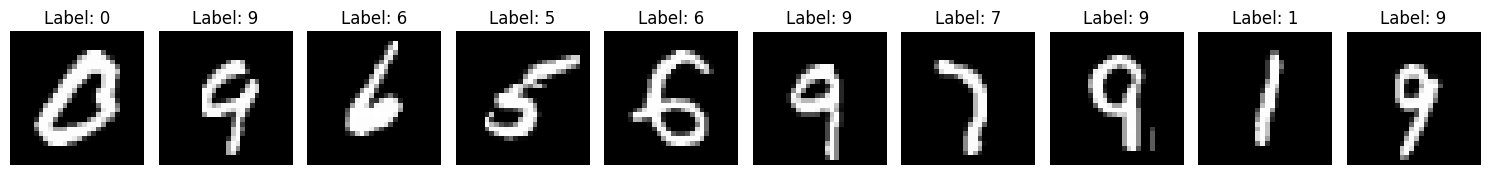

In [6]:
visualize_samples(train_loader, num_samples=10)

In [7]:
# Define a classification model
class CNN(torch.nn.Module):
    def __init__(
        self,
        in_channels=1,
        num_classes=10,
        num_filters=16,
    ):
        super().__init__()
        layers = []
        # Convolutional layers
        # TODO: implement the convolutional layers
        ###
        layers.append(torch.nn.Conv2d(in_channels, num_filters, kernel_size=3, padding=1))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))
        layers.append(torch.nn.Conv2d(num_filters, num_filters * 2, kernel_size=3, padding=1))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Conv2d(num_filters * 2, num_filters * 2, kernel_size=3, padding=1))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))
        ###

        # MLP layers
        layers.append(torch.nn.Flatten())
        layers.append(torch.nn.Linear(num_filters * 2 * 7 * 7, num_classes))
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)


model = CNN()
model = model.to(device)

# Print the model architecture
print(f"Model architecture:\n{model}")

# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Define a loss function
loss_function = torch.nn.CrossEntropyLoss()

Model architecture:
CNN(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1568, out_features=10, bias=True)
  )
)


In [8]:
img_test = torch.zeros((1, 1, 28, 28), dtype=torch.float32).to(device)
# Test the model with a dummy input
try:
    output = model(img_test)
    print("Model is working correctly with a dummy input.")
    print(f"Input shape: {img_test.shape}")
    print(f"Output shape: {output.shape}")
except Exception as e:
    print(f"Model failed with a dummy input: {e}")

Model is working correctly with a dummy input.
Input shape: torch.Size([1, 1, 28, 28])
Output shape: torch.Size([1, 10])


In [9]:
# Train the model
def train_epoch(
    model: torch.nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_function: torch.nn.Module,
) -> float:
    model.train()
    total_loss = 0.0

    # TODO: train the model for one epoch
    ###
    for batch_idx, (labels, images) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item():.4f}")
    ###
    return total_loss / len(dataloader)

# Evaluate the model on validation set
def evaluate_model(
    model: torch.nn.Module,
    dataloader: DataLoader,
) -> float:
    model.eval()
    total_loss = 0.0

    val_accuracy = 0.0
    total = 0

    # TODO: evaluate the model on validation set
    ###
    with torch.no_grad():
        for labels, images in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            val_accuracy += (predicted == labels).sum().item()
    ###

    average_loss = total_loss / len(dataloader)
    val_accuracy = val_accuracy / total
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Loss: {average_loss:.4f}")
    return average_loss

In [10]:
epoch = 2
loss_min: float = 1e100

train_loss_tot = []
eval_loss_tot = []

for _epoch in range(epoch):
    print(f"Epoch {_epoch + 1}/{epoch}")
    train_loss = train_epoch(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        loss_function=loss_function,
    )
    eval_loss = evaluate_model(
        model=model,
        dataloader=val_loader,
    )

    train_loss_tot.append(train_loss)
    eval_loss_tot.append(eval_loss)

    if eval_loss < loss_min:
        loss_min = eval_loss
        print(f"New minimum validation loss: {loss_min:.4f}")
        torch.save(model.state_dict(), ROOT / "best_model.pth")
        print("Model saved.")
    else:
        print("No improvement in validation loss. Model not saved.")

Epoch 1/2
Batch 0, Loss: 3.3181
Batch 100, Loss: 0.1226
Batch 200, Loss: 0.1420
Batch 300, Loss: 0.0665
Batch 400, Loss: 0.0139
Batch 500, Loss: 0.1013
Batch 600, Loss: 0.0520
Batch 700, Loss: 0.0697
Batch 800, Loss: 0.0816
Validation Accuracy: 0.9886
Validation Loss: 0.0388
New minimum validation loss: 0.0388
Model saved.
Epoch 2/2
Batch 0, Loss: 0.0733
Batch 100, Loss: 0.0112
Batch 200, Loss: 0.0684
Batch 300, Loss: 0.1411
Batch 400, Loss: 0.0585
Batch 500, Loss: 0.0295
Batch 600, Loss: 0.0065
Batch 700, Loss: 0.2202
Batch 800, Loss: 0.1442
Validation Accuracy: 0.9864
Validation Loss: 0.0474
No improvement in validation loss. Model not saved.


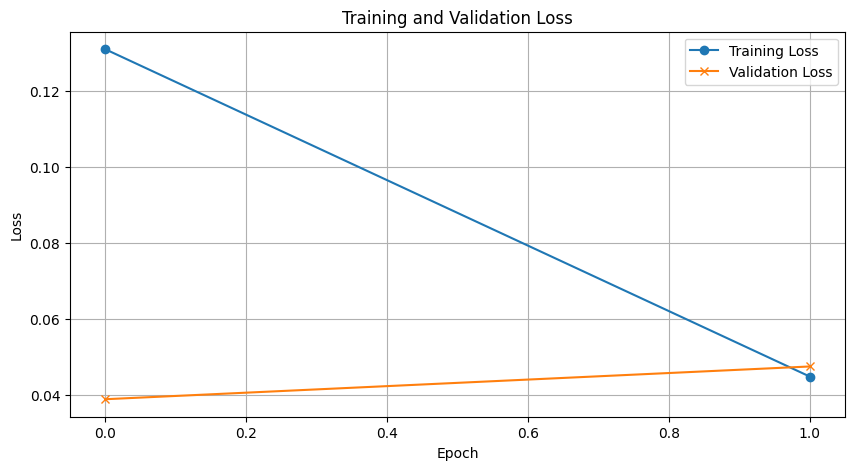

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_tot, label="Training Loss", marker="o")
plt.plot(eval_loss_tot, label="Validation Loss", marker="x")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [12]:
# test the model on test set
def test_model(
    model: torch.nn.Module,
    dataloader: DataLoader,
) -> float:
    model.eval()
    total_loss = 0.0

    test_accuracy = 0.0
    total = 0

    # TODO: test the model on test set
    ###
    with torch.no_grad():
        for labels, images in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            test_accuracy += (predicted == labels).sum().item()
    ###

    average_loss = total_loss / len(dataloader)
    accuracy = test_accuracy / total
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Loss: {average_loss:.4f}")
    return average_loss


checkpoint_path = ROOT / "best_model.pth"
if checkpoint_path.exists():
    best_model = CNN()
    best_model.load_state_dict(torch.load(checkpoint_path))
    best_model = best_model.to(device)
    print(f"Model loaded from {checkpoint_path}.")
else:
    print(f"Checkpoint {checkpoint_path} does not exist. Please check the path.")

Model loaded from best_model.pth.


In [13]:
test_loss = test_model(
    model=model,
    dataloader=test_loader,
)

Test Accuracy: 0.9848
Test Loss: 0.0492


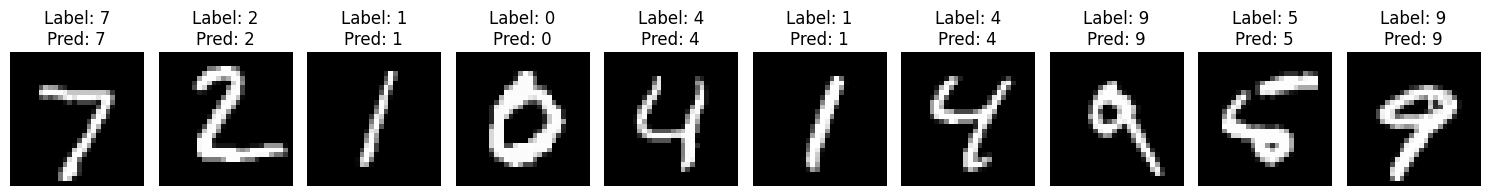

In [15]:
# plot the resutls
def plot_results(
    model: CNN,
    dataloader: DataLoader,
    num_samples: int = 10,
) -> None:
    model.eval()
    labels, images = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        classification_output = model(images)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 8))

    vmax = images.max().item()
    vmin = images.min().item()

    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    classification_output = classification_output.cpu().numpy()

    for i in range(num_samples):
        # plot image and label, prediction
        axes[i].imshow(images[i].squeeze(), cmap="gray", vmin=vmin, vmax=vmax)
        axes[i].axis("off")
        axes[i].set_title(
            f"Label: {labels[i].item()}\nPred: {classification_output[i].argmax()}"
        )

    plt.tight_layout()
    plt.show()


plot_results(
    model=best_model,
    dataloader=test_loader,
    num_samples=10,
)